# Stats - absolute anomalies, seasonal and annual

$$
z_{anomaly} = \frac{1}{30} \displaystyle\sum_{y=1}^{30}
(\bar{x}_y - \bar{x}_{hist})\ (\textrm{kg DM ha}^{-1})
$$

- calculate annual means (or seasonal means for each year)
- calculate the historical mean from the annual means
- calculate difference
- interannual reduction
- ensemble reduction

In [1]:
import importlib
import climag.climag as cplt
import geopandas as gpd
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# mask for offshore areas
ie_bbox = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="ne_10m_land_2157_IE_BBOX_DIFF",
)
# mask for non-pasture areas
mask = gpd.read_file(
    os.path.join("data", "boundaries", "boundaries_all.gpkg"),
    layer="CLC_2018_MASK_PASTURE_2157_IE",
)

In [3]:
importlib.reload(cplt)

<module 'climag.climag' from '/mnt/Backup/Documents/Git/ClimAg/ClimAg/climag/climag.py'>

## EURO-CORDEX

In [3]:
ds_ec = cplt.load_all_data("EURO-CORDEX")

/mnt/Backup/Documents/Git/ClimAg/ClimAg/.venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.24.2
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [5]:
ds_ec_norm = cplt.calc_anomaly_absolute(ds_ec, seasonal=True, skipna=True)

In [6]:
# get interannual mean, and then the ensemble mean
ds_ec_norm_reduced = ds_ec_norm.mean(dim="year", skipna=True).mean(
    dim="model", skipna=True
)

In [7]:
ds_ec_norm = cplt.calc_anomaly_absolute(ds_ec, skipna=True)

In [8]:
# get interannual mean, and then the ensemble mean
ds_ec_norm_reduced_ann = ds_ec_norm.mean(dim="year", skipna=True).mean(
    dim="model", skipna=True
).assign_coords(season="All seasons").expand_dims(dim="season")

In [9]:
ds_ec_norm = xr.merge([ds_ec_norm_reduced, ds_ec_norm_reduced_ann])

In [10]:
ds_ec_norm = ds_ec_norm.reindex(season=["All seasons", "DJF", "MAM", "JJA", "SON"])

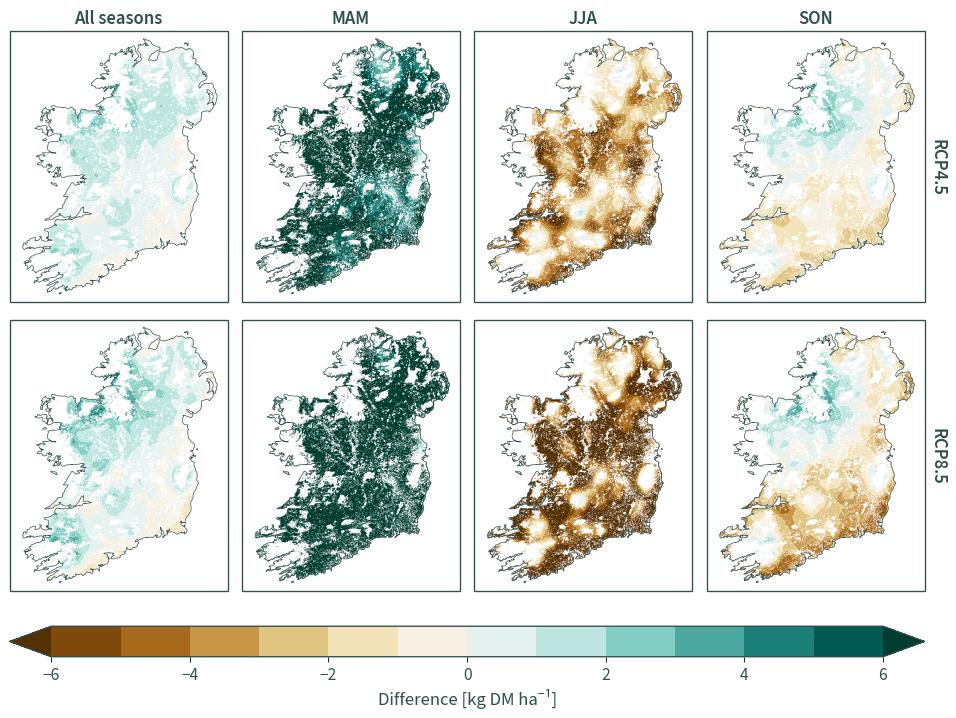

In [12]:
cplt.plot_stats(ds_ec_norm.sel(season=["All seasons", "MAM", "JJA", "SON"]).sel(exp=["rcp45", "rcp85"])["gro"], cplt.projection_eurocordex, mask, ie_bbox, label="Difference [kg DM ha⁻¹]", row="exp", col="season", levels=np.arange(-6, 6 + 1, 1))

## HiResIreland

In [4]:
ds_hr = cplt.load_all_data("HiResIreland")

In [14]:
ds_hr_norm = cplt.calc_anomaly_absolute(ds_hr, seasonal=True, skipna=True)

In [15]:
ds_hr_norm_reduced = ds_hr_norm.mean(dim="year", skipna=True).mean(
    dim="model", skipna=True
)

In [16]:
ds_hr_norm = cplt.calc_anomaly_absolute(ds_hr, skipna=True)

In [17]:
# get interannual mean, and then the ensemble mean
ds_hr_norm_reduced_ann = ds_hr_norm.mean(dim="year", skipna=True).mean(
    dim="model", skipna=True
).assign_coords(season="All seasons").expand_dims(dim="season")

In [18]:
ds_hr_norm = xr.merge([ds_hr_norm_reduced, ds_hr_norm_reduced_ann])

In [19]:
ds_hr_norm = ds_hr_norm.reindex(season=["All seasons", "DJF", "MAM", "JJA", "SON"])

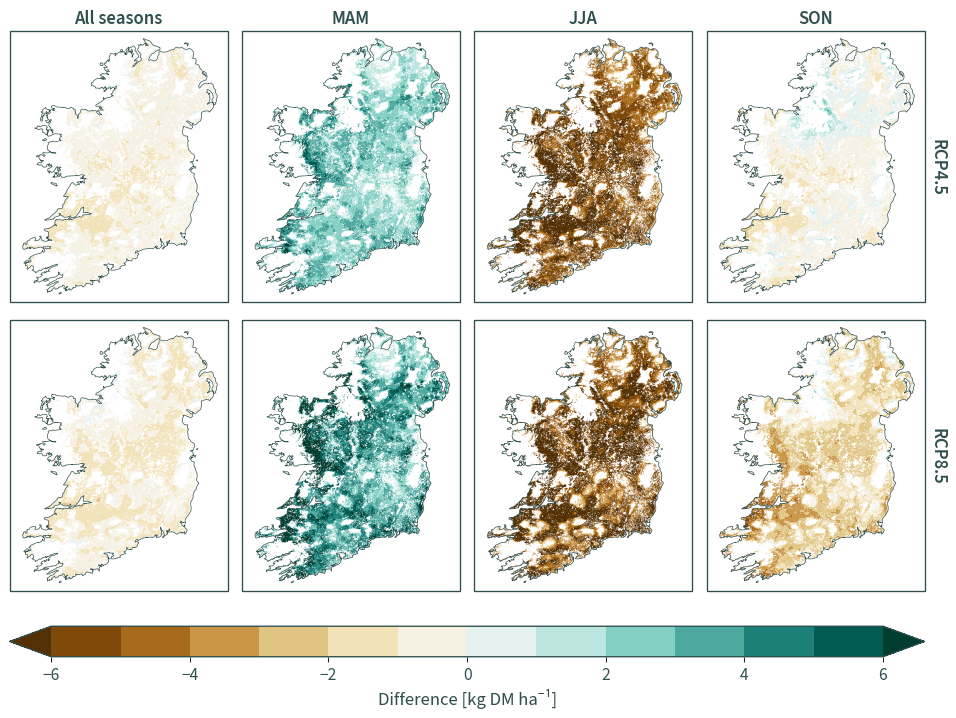

In [21]:
cplt.plot_stats(ds_hr_norm.sel(season=["All seasons", "MAM", "JJA", "SON"]).sel(exp=["rcp45", "rcp85"])["gro"], cplt.projection_hiresireland, mask, ie_bbox, label="Difference [kg DM ha⁻¹]", row="exp", col="season", levels=np.arange(-6, 6 + 1, 1))

## Boxplots

In [5]:
ds_ec_avg = cplt.calc_annual_mean(ds_ec, False, True, "mean")
ds_ec_sns = cplt.calc_annual_mean(ds_ec, True, True, "mean")
df1 = ds_ec_avg.mean(dim="model", skipna=True).mean(dim=["rlat", "rlon"], skipna=True)["gro"].to_dataframe().reset_index()[["year", "exp", "gro"]].dropna()
df2 = ds_ec_sns.mean(dim="model", skipna=True).mean(dim=["rlat", "rlon"], skipna=True)["gro"].to_dataframe().reset_index()[["year", "exp", "season", "gro"]].dropna()
df1["season"] = "All seasons"
df1["data"] = "EURO-CORDEX"
df2["data"] = "EURO-CORDEX"

In [6]:
ds_hr_avg = cplt.calc_annual_mean(ds_hr, False, True, "mean")
ds_hr_sns = cplt.calc_annual_mean(ds_hr, True, True, "mean")
df3 = ds_hr_avg.mean(dim="model", skipna=True).mean(dim=["rlat", "rlon"], skipna=True)["gro"].to_dataframe().reset_index()[["year", "exp", "gro"]].dropna()
df4 = ds_hr_sns.mean(dim="model", skipna=True).mean(dim=["rlat", "rlon"], skipna=True)["gro"].to_dataframe().reset_index()[["year", "exp", "season", "gro"]].dropna()
df3["season"] = "All seasons"
df3["data"] = "HiResIreland"
df4["data"] = "HiResIreland"

In [7]:
df = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)

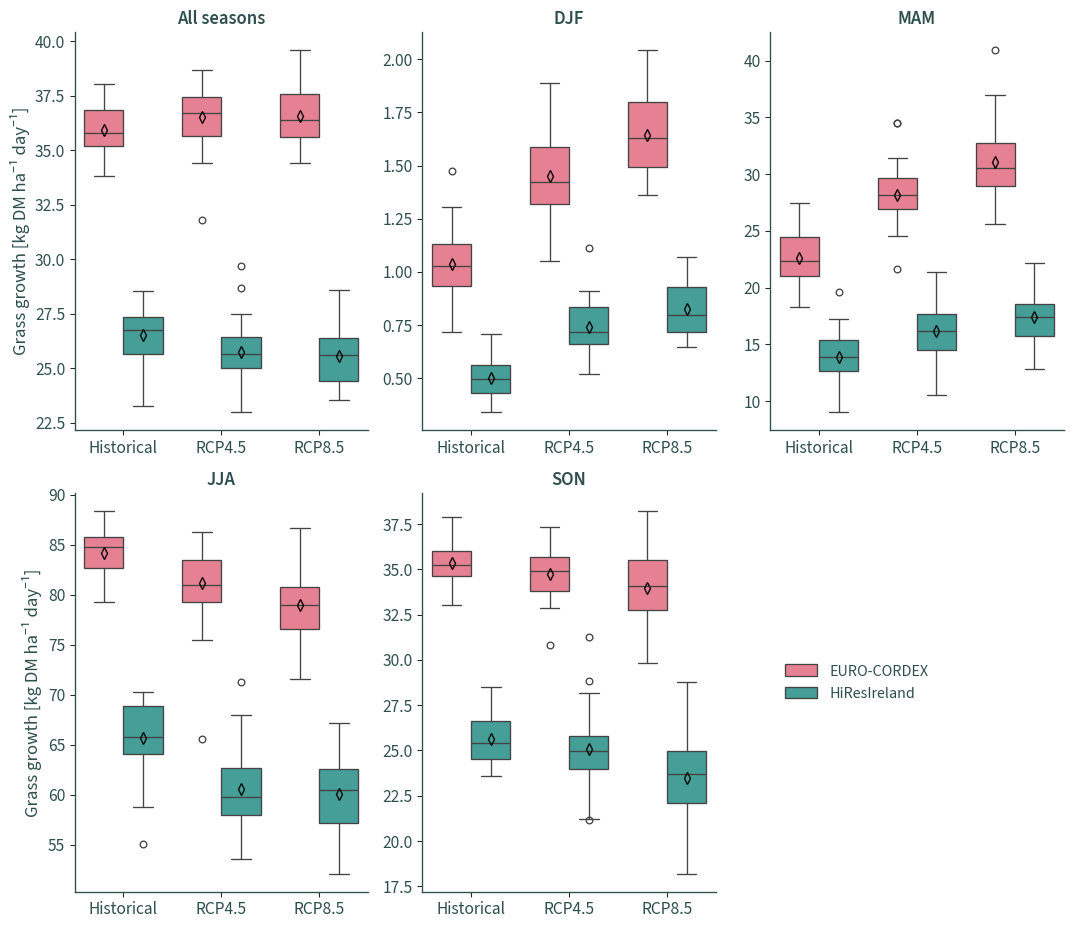

In [8]:
g = sns.catplot(df, kind="box", y="gro", col="season", hue="data", x="exp", sharey=False, sharex=False, col_wrap=3, legend_out=False, gap=0, showmeans=True,
        meanprops={
            "marker": "d",
            "markeredgecolor": "black",
            "markerfacecolor": "none",
        }, errorbar=("pi", 100), palette="husl", aspect=0.75)
g.set_axis_labels("", "Grass growth [kg DM ha⁻¹ day⁻¹]")
g.set_xticklabels(["Historical", "RCP4.5", "RCP8.5"])
g.set_titles("{col_name}")
sns.move_legend(g, "lower right", bbox_to_anchor=(0.875, 0.25), frameon=False, title=None, fontsize=12)
plt.show()